In [1]:
import os
import sys
import random
import pandas as pd
from pathlib import Path
import numpy as np
import torch

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)

from one.api import ONE

seed = 666
set_seed(seed)

/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/__init__.py:202: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '


In [ ]:
class Hier_Reduced_Rank_Model(nn.Module):
    def __init__(
        self, 
        n_roi,
        n_units, 
        n_t_bin, 
        roi_idx,
        rank_V,
        rank_B
    ):
        super(Hier_Reduced_Rank_Model, self).__init__()
        
        self.n_roi = n_roi
        self.n_sess = len(n_units)
        self.n_units = n_units
        self.n_t_bin = n_t_bin
        self.roi_idx = roi_idx
        self.rank_V = rank_V
        self.rank_B = rank_B
        
        self.Us = nn.ParameterList(
            [nn.Parameter(torch.randn(self.n_units[i], self.rank_V)) for i in range(self.n_sess)]
        )
        self.A = nn.Parameter(torch.randn(self.n_roi, self.rank_V, self.rank_B)) 
        self.B = nn.Parameter(
            torch.randn(self.rank_B, self.n_t_bin)
        ) 
        self.intercepts = nn.ParameterList(
            [nn.Parameter(torch.randn(1,)) for i in range(self.n_sess)]
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, datasets):
        preds, gt = [], []
        for sess_idx, dataset in enumerate(datasets):
            X, Y = dataset
            n_trials, n_units, n_t_bins = X.shape
            self.Vs = torch.einsum("ijk,kt->ijt", self.A, self.B)
            Beta = torch.einsum("cr,rt->ct", self.Us[sess_idx], self.Vs[self.roi_idx[sess_idx]])
            out = torch.einsum("ct,kct->k", Beta, X)
            out += self.intercepts[sess_idx] * torch.ones(n_trials)
            out = self.sigmoid(out)
            preds.append(out)
            gt.append(Y)
        return preds, gt

In [ ]:
def train_multi_region(
    model,
    train_dataset,
    loss_function=nn.BCELoss(),
    learning_rate=1e-3,
    weight_decay=1e-3,
    n_epochs=7000,
):
    
    n_sess = len(train_dataset)
    
    optimizer = optim.Adam(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=weight_decay
    )
    print_every_epochs = n_epochs//10

    train_losses = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        train_prob, train_Y = model(train_dataset)
            
        losses = torch.zeros((n_sess,))
        for sess_idx in range(n_sess):
            losses[sess_idx] = loss_function(train_prob[sess_idx], train_Y[sess_idx])
        loss = losses.mean()
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(losses.detach().numpy())
        if (epoch + 1) % print_every_epochs == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item()}")

    return train_losses

from sklearn.metrics import accuracy_score, roc_auc_score

def model_eval(model, test_dataset):
    
    n_sess = len(test_dataset)
    
    with torch.no_grad():
        
        test_prob, test_Y = model(test_dataset)
            
        test_metrics = []
        for sess_idx in range(n_sess):
            test_pred = np.array(test_prob[sess_idx] >= 0.5) * 1.
            test_acc = accuracy_score(test_Y[sess_idx], test_pred)
            try:
                test_auc = roc_auc_score(test_Y[sess_idx], test_prob[sess_idx])
            except:
                test_auc = np.nan
            print(f"session {sess_idx} test acc: {test_acc:.3f} auc: {test_auc:.3f}")
            test_metrics.append([test_acc, test_auc])
                    
        return test_metrics, test_prob

In [ ]:
train_losses = train_multi_region(
    model=hier_rrr,
    train_dataset=DATASETS,
    loss_function=torch.nn.BCELoss(),
    learning_rate=1e-3,
    weight_decay=1e-3,
    n_epochs=7000,
)

_, _ = model_eval(hier_rrr, DATASETS)

In [2]:
# regions = ["VISp", "CA1", "LP", "PO"]
regions = ["PO", "GRN"]
n_sess = 10

In [3]:
TRAIN_DATASETS = []
TEST_DATASETS = []
N_UNITS = []
REGION_INDEX = []
PID_INDEX = []

pid_idx = 0
for roi_idx, roi in enumerate(regions):
    
    one = ONE(base_url="https://openalyx.internationalbrainlab.org", mode='remote')
    pids_per_region = one.search_insertions(atlas_acronym=[roi], query_type='remote')
    print(f"{roi}: {len(pids_per_region)} PIDs")
    pids = list(pids_per_region)[:n_sess]
    
    X_dict, Y_dict = load_data_from_pids(
        pids,
        brain_region=roi.lower(),
        behavior="choice",
        data_type="all_ks",
        n_t_bins = 40,
    )
    loaded_pids = list(X_dict.keys())
    
    for _, pid in enumerate(loaded_pids):
        X, Y = X_dict[pid], Y_dict[pid]
        n_trials, n_units, n_t_bins = X.shape
        X = sliding_window_over_trials(X, half_window_size=0).squeeze()
        Y = sliding_window_over_trials(Y, half_window_size=0).squeeze()
        X, Y = torch.tensor(X), torch.tensor(Y)
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
        TRAIN_DATASETS.append((X_train, Y_train))
        TEST_DATASETS.append((X_test, Y_test))
        N_UNITS.append(n_units)
        REGION_INDEX.append(roi_idx)
        PID_INDEX.append(pid_idx)
        pid_idx += 1

PO: 68 PIDs


/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: ebce500b-c530-47de-8cb1-963c552703ea
pid: 8c732bf2-639d-496c-bf82-464bc9c2d54b
number of trials found: 470
found 470 trials from 13.74 to 5761.52 sec.
found 511 Kilosort units in region po


Compute spike count: 100%|████████████████████| 470/470 [00:10<00:00, 45.54it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 15b69921-d471-4ded-8814-2adad954bcd8
pid: 7a620688-66cb-44d3-b79b-ccac1c8ba23e
number of trials found: 715
found 715 trials from 28.03 to 3547.82 sec.
found 131 Kilosort units in region po


Compute spike count: 100%|███████████████████| 715/715 [00:03<00:00, 196.52it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: f4eb56a4-8bf8-4bbc-a8f3-6e6535134bad
pid: bef05a5c-68c3-4513-87c7-b3151c88da8e
number of trials found: 489
found 489 trials from 101.15 to 3448.76 sec.
found 10 Kilosort units in region po


Compute spike count: 100%|█████████████████| 489/489 [00:00<00:00, 19842.06it/s]
/home/yizi/side_info_decoding/side_info_decoding/utils.py:99: RuntimeWarning: divide by zero encountered in divide
  data_norm[:,t*n_units:(t+1)*n_units] = (data_norm[:,t*n_units:(t+1)*n_units] - mean_per_trial) / std_per_trial
/home/yizi/side_info_decoding/side_info_decoding/utils.py:99: RuntimeWarning: invalid value encountered in divide
  data_norm[:,t*n_units:(t+1)*n_units] = (data_norm[:,t*n_units:(t+1)*n_units] - mean_per_trial) / std_per_trial
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 37ac03f1-9831-4a30-90fc-a59e635b98bd
pid: 8b31b4bd-003e-4816-a3bf-2df4cc3558f8
number of trials found: 432
found 432 trials from 65.86 to 2896.15 sec.
found 103 Kilosort units in region po


Compute spike count: 100%|██████████████████| 432/432 [00:00<00:00, 1546.79it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: be164a14-6e73-42c3-ab60-d29c48693c0f
pid: 77121d92-6dde-4243-ab54-0a99efa22e99
number of trials found: 376
found 376 trials from 79.72 to 2748.78 sec.
found 225 Kilosort units in region po


Compute spike count: 100%|███████████████████| 376/376 [00:00<00:00, 416.72it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 3bb54985-77b2-421d-9d1f-46185be51216
pid: 81950362-ed95-4662-997f-e119bbd594d1
number of trials found: 648
found 648 trials from 49.35 to 3147.13 sec.
found 10 Kilosort units in region po


Compute spike count: 100%|██████████████████| 648/648 [00:00<00:00, 2467.64it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 87ad026d-5b95-4022-8d59-c260870d830f
pid: 4f922a5b-5014-455d-8cd5-7caed78af615
number of trials found: 812
found 812 trials from 65.33 to 3887.55 sec.
found 32 Kilosort units in region po


Compute spike count: 100%|██████████████████| 812/812 [00:00<00:00, 4325.34it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 2038e95d-64d4-4ecb-83d0-1308d3c598f8
pid: 1a924329-65aa-465d-b201-c2dd898aebd0
number of trials found: 481
found 481 trials from 61.03 to 2940.03 sec.
found 70 Kilosort units in region po


Compute spike count: 100%|███████████████████| 481/481 [00:00<00:00, 979.22it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: a2ec6341-c55f-48a0-a23b-0ef2f5b1d71e
pid: 5135e93f-2f1f-4301-9532-b5ad62548c49
number of trials found: 364
found 364 trials from 76.32 to 3810.93 sec.
found 157 Kilosort units in region po


Compute spike count: 100%|██████████████████| 364/364 [00:00<00:00, 1267.71it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 8928f98a-b411-497e-aa4b-aa752434686d
pid: ad714133-1e03-4d3a-8427-33fc483daf1a
number of trials found: 583
found 583 trials from 112.34 to 3275.94 sec.
found 294 Kilosort units in region po


Compute spike count: 100%|███████████████████| 583/583 [00:03<00:00, 151.99it/s]


GRN: 17 PIDs


/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: c958919c-2e75-435d-845d-5b62190b520e
pid: cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
number of trials found: 705
found 705 trials from 79.14 to 3939.10 sec.
found 261 Kilosort units in region grn


Compute spike count: 100%|███████████████████| 705/705 [00:06<00:00, 105.47it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 32d27583-56aa-4510-bc03-669036edad20
pid: 2e720cee-05cc-440e-a24b-13794b1ac01d
number of trials found: 682
found 682 trials from 28.94 to 3431.07 sec.
found 81 Kilosort units in region grn


Compute spike count: 100%|███████████████████| 682/682 [00:02<00:00, 295.03it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 7cec9792-b8f9-4878-be7e-f08103dc0323
pid: e17db2b6-b778-4e2a-845c-c4d040b0c875
number of trials found: 542
found 542 trials from 307.48 to 2989.17 sec.
found 20 Kilosort units in region grn


Compute spike count: 100%|██████████████████| 542/542 [00:00<00:00, 1995.71it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: aec5d3cc-4bb2-4349-80a9-0395b76f04e2
pid: 7332e6cf-9847-4aca-b2e3-d864989dd0fb
number of trials found: 581
found 581 trials from 29.78 to 2802.68 sec.
found 261 Kilosort units in region grn


Compute spike count: 100%|███████████████████| 581/581 [00:05<00:00, 103.89it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 25d1920e-a2af-4b6c-9f2e-fc6c65576544
pid: c0e59477-43f0-4441-9f81-3a55ddad9dad
number of trials found: 358
found 358 trials from 9.42 to 2224.60 sec.
found 99 Kilosort units in region grn


Compute spike count: 100%|███████████████████| 358/358 [00:00<00:00, 364.71it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 571d3ffe-54a5-473d-a265-5dc373eb7efc
pid: aecd7612-b5c5-4ad2-9e76-e5b783387e47
number of trials found: 359
found 359 trials from 14.38 to 2766.52 sec.
found 74 Kilosort units in region grn


Compute spike count: 100%|███████████████████| 359/359 [00:00<00:00, 851.52it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 75b6b132-d998-4fba-8482-961418ac957d
pid: 6a098711-5423-4072-8909-7cff0e2d4531
number of trials found: 403
found 403 trials from 49.05 to 3074.29 sec.
found 71 Kilosort units in region grn


Compute spike count: 100%|██████████████████| 403/403 [00:00<00:00, 2600.25it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 746d1902-fa59-4cab-b0aa-013be36060d5
pid: 39883ded-f5a2-4f4f-a98e-fb138eb8433e
number of trials found: 561
found 561 trials from 39.62 to 4058.39 sec.
found 132 Kilosort units in region grn


Compute spike count: 100%|███████████████████| 561/561 [00:02<00:00, 211.90it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 671c7ea7-6726-4fbe-adeb-f89c2c8e489b
pid: 04c9890f-2276-4c20-854f-305ff5c9b6cf
number of trials found: 700
found 700 trials from 109.27 to 3491.16 sec.
found 248 Kilosort units in region grn


Compute spike count: 100%|████████████████████| 700/700 [00:07<00:00, 96.00it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: eebacd5a-7dcd-4ba6-9dff-ec2a4d2f19e0
pid: df6012d0-d921-4d0a-af2a-2a91030d0f42
number of trials found: 554
found 554 trials from 56.17 to 2721.08 sec.
found 106 Kilosort units in region grn


Compute spike count: 100%|███████████████████| 554/554 [00:03<00:00, 182.38it/s]


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.utilities import CombinedLoader

In [5]:
class SessionDataset:
    def __init__(self, dataset, roi_idx, pid_idx, **kargs):
        
        self.X, self.Y = dataset
        self.n_trials = self.X.shape[0]
        self.n_units = self.X.shape[1]
        self.roi_idx = roi_idx
        self.pid_idx = pid_idx
        
    def __len__(self):
        return self.n_trials
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index], self.roi_idx, self.pid_idx

In [6]:
def dataloader(datasets, regions, sess_ids, batch_size=32): 
    
    loaders = []
    for i, dataset in enumerate(datasets):
        sess_dataset = SessionDataset(dataset, regions[i], sess_ids[i])
        loaders.append(DataLoader(
            sess_dataset, batch_size = batch_size
        ))
    return loaders

In [7]:
train_loaders = dataloader(TRAIN_DATASETS, REGION_INDEX, PID_INDEX, batch_size=128)

In [8]:
test_loaders = dataloader(TEST_DATASETS, REGION_INDEX, PID_INDEX, batch_size=128)

In [9]:
train_loaders = CombinedLoader(train_loaders, mode="min_size")
test_loaders = CombinedLoader(test_loaders, mode="min_size")

In [10]:
class Hier_Reduced_Rank_Model(nn.Module):
    def __init__(
        self, 
        n_roi,
        n_units, 
        n_t_bin, 
        rank_V,
        rank_B
    ):
        super(Hier_Reduced_Rank_Model, self).__init__()
        
        self.n_roi = n_roi
        self.n_sess = len(n_units)
        self.n_units = n_units
        self.n_t_bin = n_t_bin
        self.rank_V = rank_V
        self.rank_B = rank_B
        
        self.Us = nn.ParameterList(
            [nn.Parameter(torch.randn(self.n_units[i], self.rank_V)) for i in range(self.n_sess)]
        )
        self.A = nn.Parameter(torch.randn(self.n_roi, self.rank_V, self.rank_B)) 
        self.B = nn.Parameter(
            torch.randn(self.rank_B, self.n_t_bin)
        ) 
        self.intercepts = nn.ParameterList(
            [nn.Parameter(torch.randn(1,)) for i in range(self.n_sess)]
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, datasets):
        pred_lst, gt_lst = [], []
        for dataset in datasets:
            X, Y, roi_idx, sess_idx = dataset
            roi_idx = torch.unique(roi_idx)
            sess_idx = torch.unique(sess_idx)
            n_trials, n_units, n_t_bins = X.shape
            self.Vs = torch.einsum("ijk,kt->ijt", self.A, self.B)
            Beta = torch.einsum("cr,rt->ct", self.Us[sess_idx], self.Vs[roi_idx].squeeze())
            out = torch.einsum("ct,kct->k", Beta, X)
            out += self.intercepts[sess_idx] * torch.ones(n_trials)
            out = self.sigmoid(out)
            pred_lst.append(out)
            gt_lst.append(Y)
        return pred_lst, gt_lst

In [11]:
# https://lightning.ai/docs/pytorch/stable/common/lightning_module.html
import lightning as L 
from torchmetrics.functional import accuracy
from torchmetrics import AUROC

class LitHierRRR(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch):
        # training_step defines the train loop.
        # it is independent of forward
        losses = 0
        pred_lst, gt_lst = self.model(batch)
        for i in range(len(batch)):
            losses += nn.BCELoss()(pred_lst[i], gt_lst[i])
        loss = losses / len(batch)
        self.log("loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch):
        accs, aucs = self._shared_eval_step(batch)
        metrics = {"val_acc": np.mean(accs), "val_auc": np.mean(aucs)}
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
    
    def test_step(self, batch):
        accs, aucs = self._shared_eval_step(batch)
        for i in range(len(batch)):
            print(f"session {i} test_acc {accs[i]} test_auc {aucs[i]}")

    def _shared_eval_step(self, batch):
        pred_lst, gt_lst = self.model(batch)
        accs, aucs = [], []
        for i in range(len(batch)):
            auroc = AUROC(task="binary")
            acc = accuracy(pred_lst[i], gt_lst[i], task="binary")
            auc = auroc(pred_lst[i], gt_lst[i])
            accs.append(acc)
            aucs.append(auc)
        return accs, aucs
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-3)
        return optimizer

In [12]:
hier_rrr = Hier_Reduced_Rank_Model(
    n_roi = len(regions),
    n_units = N_UNITS, 
    n_t_bin = 40, 
    rank_V = 2,
    rank_B = 5
)

In [13]:
lit_hier_rrr = LitHierRRR(hier_rrr)

In [14]:
trainer = L.Trainer(max_epochs=1000)
trainer.fit(model=lit_hier_rrr, 
            train_dataloaders=train_loaders)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-01-21 23:54:57.493053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 23:54:58.241045: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yizi/anaconda3/envs/point_cloud/lib/python3.

Epoch 1:  67%|█████████▎    | 2/3 [00:00<00:00, 14.92it/s, v_num=24, loss=35.80]

/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 120. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 999: 100%|████████████| 3/3 [00:00<00:00, 15.79it/s, v_num=24, loss=0.112]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|████████████| 3/3 [00:00<00:00, 15.09it/s, v_num=24, loss=0.112]


In [15]:
trainer.test(dataloaders=test_loaders)

/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/yizi/side_info_decoding/notebooks/lightning_logs/version_24/checkpoints/epoch=999-step=3000.ckpt
Loaded model weights from the checkpoint at /home/yizi/side_info_decoding/notebooks/lightning_logs/version_24/checkpoints/epoch=999-step=3000.ckpt
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoade

Testing DataLoader 0:   0%|                               | 0/1 [00:00<?, ?it/s]session 0 test_acc 0.6382978558540344 test_auc 0.7059090909090908
session 1 test_acc 0.734375 test_auc 0.7872340425531914
session 2 test_acc 0.47959184646606445 test_auc 0.4977054651647893
session 3 test_acc 0.6551724076271057 test_auc 0.7178378378378378
session 4 test_acc 0.7368420958518982 test_auc 0.8038808038808039
session 5 test_acc 0.6953125 test_auc 0.742661943319838
session 6 test_acc 0.5859375 test_auc 0.6003503503503503
session 7 test_acc 0.6288659572601318 test_auc 0.7054263565891472
session 8 test_acc 0.698630154132843 test_auc 0.7526395173453997
session 9 test_acc 0.8376068472862244 test_auc 0.9310754604872251
session 10 test_acc 0.8984375 test_auc 0.9220430107526881
session 11 test_acc 0.8671875 test_auc 0.9506715506715506
session 12 test_acc 0.7155963182449341 test_auc 0.7238095238095239
session 13 test_acc 0.9487179517745972 test_auc 0.9902366863905325
session 14 test_acc 0.8611111044883728 

[{}]

In [16]:
Vs = hier_rrr.Vs.detach().numpy()

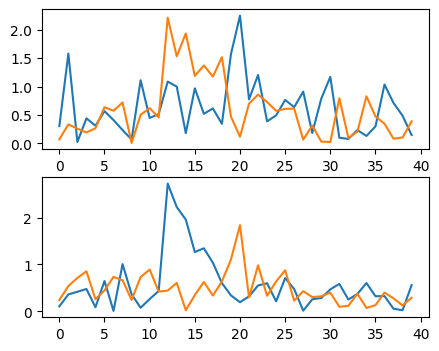

In [17]:
fig, axes = plt.subplots(len(regions), 1, figsize=(5,2*len(regions)))
for i, ax in enumerate(axes):
    ax.plot(np.abs(Vs[i].T));